### Calculate Total Water Level for a range of slopes
* Replace time series of water levels plot in _plot_model_and_observations_.
* Calculate a bunch of slopes for a range of R2 calcs

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import pickle
from matplotlib import cm
from datetime import datetime
from pyproj import Transformer

In [15]:
def calcR2(H, T, slope, igflag=0):
    """
    %
    % [R2, S, setup,  Sinc,  SIG,  ir] = calcR2(H, T, slope, igflag);
    %
    % Calculated 2% runup (R2), swash (S), setup (setup), incident swash (Sinc)
    % and infragravity swash (SIG) elevations based on parameterizations from runup paper
    % also Iribarren (ir)
    % August 2010 - Included 15% runup (R16) statistic that, for a Guassian distribution,
    % represents mean+sigma. It is calculated as R16 = setup + swash/4.
    % In a wave tank, Palmsten et al (2010) found this statistic represented initiation of dune erosion.
    %
    %
    % H = significant wave height, reverse shoaled to deep water
    % T = deep-water peak wave period
    % slope = radians
    % igflag = 0 (default)use full equation for all data
    %        = 1  use dissipative-specific calculations when dissipative conditions exist (Iribarren < 0.3)
    %        = 2  use dissipative-specific (IG energy) calculation for all data
    %
    % based on:
    %  Stockdon, H. F., R. A. Holman, P. A. Howd, and J. Sallenger A. H. (2006),
    %    Empirical parameterization of setup, swash, and runup,
    %    Coastal Engineering, 53, 573-588.
    % author: hstockdon@usgs.gov
    # Converted to Python by csherwood@usgs.gov
    """
    g = 9.81

    # make slopes positive!
    slope = np.abs(slope)

    # compute wavelength and Iribarren
    L = (g*T**2) / (2.*np.pi)
    sqHL = np.sqrt(H*L)
    ir = slope/sqHL

    if igflag == 2:                     # use dissipative equations (IG) for ALL data
        R2 = 1.1*(0.039 * sqHL)
        S = 0.046*sqHL
        setup = 0.016*sqHL

    elif igflag == 1 and ir < 0.3:      # if dissipative site use diss equations
        R2 = 1.1*(0.039 * sqHL)
        S = 0.046*sqHL
        setup = 0.016*sqHL

    else:                               # if int/ref site, use full equations
        setup = 0.35*slope*sqHL
        Sinc = 0.75*slope*sqHL
        SIG = 0.06*sqHL
        S = np.sqrt(Sinc**2 + SIG**2)
        R2 = 1.1*(setup + S/2.)
        R16 = 1.1*(setup + S/4.)

    return R2, S, setup, Sinc, SIG, ir, R16



In [16]:
url_CSNV = 'http://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/dorian/core_banks_jcw44/Output/dorian_his.ncml'
url_CSYV = 'http://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/dorian/core_banks_jcw45/Output/dorian_his.ncml'
url_FSYV = 'http://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/dorian/core_banks_jcw50/Output/dorian_his.ncml'
url_FSNV = 'http://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/dorian/core_banks_jcw51/Output/dorian_his.ncml'
#url_CSYV = 'http://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/dorian/core_banks_jcw45/Output/dorian_his.ncml'
ds_CSYV = xr.open_dataset(url_CSYV)
ds_CSYV

<xarray.Dataset> Size: 35GB
Dimensions:                 (tracer: 4, NST: 3, s_rho: 8, s_w: 9,
                             eta_rho: 1057, xi_rho: 1317, eta_u: 1057,
                             xi_u: 1316, eta_v: 1056, xi_v: 1317,
                             eta_psi: 1056, xi_psi: 1316, ocean_time: 37,
                             NVEG: 3, Nbed: 1)
Coordinates:
  * s_rho                   (s_rho) float64 64B -0.9375 -0.8125 ... -0.0625
  * s_w                     (s_w) float64 72B -1.0 -0.875 -0.75 ... -0.125 0.0
    lon_rho                 (eta_rho, xi_rho) float64 11MB ...
    lat_rho                 (eta_rho, xi_rho) float64 11MB ...
    lon_u                   (eta_u, xi_u) float64 11MB ...
    lat_u                   (eta_u, xi_u) float64 11MB ...
    lon_v                   (eta_v, xi_v) float64 11MB ...
    lat_v                   (eta_v, xi_v) float64 11MB ...
    lon_psi                 (eta_psi, xi_psi) float64 11MB ...
    lat_psi                 (eta_psi, xi_psi) float64 11MB ...
  * ocean_time              (ocean_time) datetime64[ns] 296B 2019-09-06T10:15...
Dimensions without coordinates: tracer, NST, eta_rho, xi_rho, eta_u, xi_u,
                                eta_v, xi_v, eta_psi, xi_psi, NVEG, Nbed
Data variables: (12/182)
    ntimes                  int32 4B ...
    ndtfast                 int32 4B ...
    dt                      float64 8B ...
    dtfast                  float64 8B ...
    dstart                  datetime64[ns] 8B ...
    nHIS                    int32 4B ...
    ...                      ...
    Dwave                   (ocean_time, eta_rho, xi_rho) float32 206MB ...
    Pwave_top               (ocean_time, eta_rho, xi_rho) float32 206MB ...
    Dissip_fric             (ocean_time, eta_rho, xi_rho) float32 206MB ...
    Dissip_break            (ocean_time, eta_rho, xi_rho) float32 206MB ...
    Dissip_wcap             (ocean_time, eta_rho, xi_rho) float32 206MB ...
    Dissip_roller           (ocean_time, eta_rho, xi_rho) float32 206MB ...
Attributes: (12/33)
    file:                      ./Output/Dorian_NCB_his_00019.nc
    format:                    netCDF-3 64bit offset file
    Conventions:               CF-1.4, SGRID-0.3
    type:                      ROMS/TOMS history file
    title:                     Hurricane Dorian North Core Banks
    var_info:                  varinfo.dat
    ...                        ...
    tiling:                    015x012
    history:                   ROMS/TOMS, Version 3.9, Saturday - October 15,...
    ana_file:                  ROMS/Functionals/ana_btflux.h, ROMS/Functional...
    CPP_options:               COREBANKS, ANA_BPFLUX, ANA_BSFLUX, ANA_BTFLUX,...
    EXTRA_DIMENSION.N:         8
    EXTRA_DIMENSION.boundary:  4

In [17]:
t=ds_CSYV.ocean_time.load()
tstring = pd.to_datetime(t).strftime('%Y-%m-%d %H:%M')
tstring

Index(['2019-09-06 10:15', '2019-09-06 10:30', '2019-09-06 10:45',
       '2019-09-06 11:00', '2019-09-06 11:15', '2019-09-06 11:30',
       '2019-09-06 11:45', '2019-09-06 12:00', '2019-09-06 12:15',
       '2019-09-06 12:30', '2019-09-06 12:45', '2019-09-06 13:00',
       '2019-09-06 13:14', '2019-09-06 13:29', '2019-09-06 13:44',
       '2019-09-06 13:59', '2019-09-06 14:14', '2019-09-06 14:29',
       '2019-09-06 14:45', '2019-09-06 15:00', '2019-09-06 15:15',
       '2019-09-06 15:30', '2019-09-06 15:45', '2019-09-06 16:00',
       '2019-09-06 16:15', '2019-09-06 16:30', '2019-09-06 16:45',
       '2019-09-06 17:00', '2019-09-06 17:15', '2019-09-06 17:30',
       '2019-09-06 17:45', '2019-09-06 18:00', '2019-09-06 18:15',
       '2019-09-06 18:30', '2019-09-06 18:45', '2019-09-06 19:00',
       '2019-09-06 19:15'],
      dtype='object')

In [18]:
print(tstring[19])
print(tstring[31])

2019-09-06 15:00
2019-09-06 18:00


In [19]:
# pick some points
ys, xs = 750,650
yo, xo = 5, 650

# load initial and final bathymetry
bathi = ds_CSYV.bath[0,yo,xo].load().values
bathf = ds_CSYV.bath[-1,yo,xo].load().values
print(bathi, bathf)

15.445326 15.432082


In [20]:
# indices for profiles separated by 10 m
idxs = np.arange(200, 810, 10)
print(idxs)

[200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370
 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550
 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730
 740 750 760 770 780 790 800]


C:\Users\csherwood\AppData\Local\Temp\1\ipykernel_16472\3675117871.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  izero = int( np.argwhere(p>=0.)[0] )
C:\Users\csherwood\AppData\Local\Temp\1\ipykernel_16472\3675117871.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  iep = int( np.argwhere( np.diff(sp)<=0 )[0] )


2 0.15115483
2 0.16501692
12 0.67892957
2 0.13264595
1 0.09016522
2 0.17557836
4 0.29957
3 0.22272395
5 0.25619775
2 0.15352191
5 0.36366653
6 0.428379
2 0.19664666
11 0.6610082
4 0.30151963
15 0.8260964
4 0.1704639
1 0.13514811
11 0.5984919
6 0.33836025
24 2.0147207
10 0.6706703
6 0.4340559
8 0.5956267
4 0.329448
7 0.481437
7 0.5606476
9 0.64642096
8 0.57743907
7 0.55694735
3 0.19557047
1 0.1083036
9 0.66818
8 0.45962837
5 0.35941657
9 0.5725434
5 0.40089038
5 0.3535404
25 1.9420888
18 0.7516834
11 0.6972757
8 0.47128564
9 0.5827171
3 0.15345255
0 0.052071285
6 0.42991793
3 0.2440905
10 0.7646195
8 0.5546094
7 0.49694327
6 0.37419128
18 0.67458904
12 0.72474134
10 0.74614996
9 0.6189991
6 0.5023522
3 0.24993995
0 0.010874385
7 0.42647249
5 0.35204783
11 0.812474
[0.02146869 0.02434739 0.03706364 0.02228274 0.         0.02556436
 0.03585642 0.02794314 0.02404262 0.02397062 0.03533524 0.04174525
 0.02444587 0.03804459 0.03435702 0.03422164 0.02233063 0.
 0.03001868 0.03374587 0.0454386 

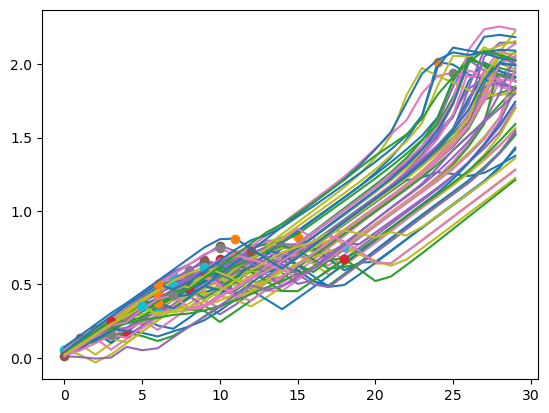

In [21]:
# calculate slopes for these profiles
s = np.nan*np.ones_like(idxs)
ix = 30
for i, idx in enumerate( idxs ):
    # grab the profile
    p = -ds_CSYV.bath[0,:,idx].load().values
    # find waterline
    izero = int( np.argwhere(p>=0.)[0] )
    # make a short profile
    sp = p[izero:izero+ix]
    # find where slope starts down
    iep = int( np.argwhere( np.diff(sp)<=0 )[0] )

    print(iep, sp[iep])
    plt.plot(sp)
    plt.plot(iep, sp[iep],'o')
    
    # make a really short profile
    rsp = sp[0:iep]
    # calculate the slope using dy = 1.5 m
    if(len(rsp>0)):
        s[i] = (rsp[-1]-rsp[0])/(len(rsp)*1.5)
       
print(s)


In [22]:
# calculate mean, 5th, and 95th percentile slopes
smean = np.nanmean(s)
s5 = np.nanpercentile(s,5)
s95 = np.nanpercentile(s,95)
print(smean, s5, s95 )

0.033543731196451994 0.01722544804215432 0.04486478082835674


In [23]:
# load time series of model output
ys, xs = 750,650
yo, xo = 50, 650
zs = ds_CSYV.zeta[:,ys,xs].load().values
zo = ds_CSYV.zeta[:,yo,xo].load().values
Hs = ds_CSYV.Hwave[:,yo,xo].load().values
T = ds_CSYV.Pwave_top[:,yo,xo].load().values
print(T)
print(Hs)
print(zo)

[11.180339 13.132638 13.132638 13.132638 13.132638 13.132638 11.180339
 11.180339 11.180339 11.180339 11.180339 11.180339 11.180339 11.180339
 11.180339 11.180339 11.180339 11.180339 11.180339 11.180339 11.180339
 11.180339 11.180339 11.180339 11.180339 11.180339 11.180339 11.180339
 11.180339  9.518269  9.518269  9.518269  9.518269  9.518269  9.518269
  9.518269  9.518269]
[4.1249847  4.090472   0.85436326 4.056225   4.0426626  4.025289
 4.002724   3.9643834  3.9161608  3.8666856  3.8128831  3.7526767
 3.694857   3.6313624  3.56431    3.484187   3.3780258  3.2297406
 3.0757039  2.9133546  2.7557967  2.6148813  2.4903736  2.382158
 2.298146   2.2405415  2.2030728  2.17153    2.131626   2.0805385
 2.0195243  1.9505155  1.8748125  1.7952744  1.7148294  1.6373688
 1.560356  ]
[ 0.6994806   0.5947283   0.40003988  0.46802476  0.44054195  0.4214852
  0.3945044   0.32277167  0.22956286  0.14020123  0.05602152 -0.02711488
 -0.08577386 -0.11026207 -0.09147077 -0.02742624  0.07081816  0.1667121

In [24]:
# arrays for output of TWL calcs
R2 = np.nan*np.ones_like(T)
R2_5 = np.nan*np.ones_like(T)
R2_95 = np.nan*np.ones_like(T)

for i in range( len(R2) ):
    R2[i], _, _, _, _, _, _ = calcR2(Hs[i], T[i], smean, igflag=0)
    R2_5[i], _, _, _, _, _, _ = calcR2(Hs[i], T[i], s5, igflag=0)
    R2_95[i], _, _, _, _, _, _ = calcR2(Hs[i], T[i], s95, igflag=0)

R2 max: 1.8289365768432617 at 2019-09-06T10:30:00.044194816
Range of mean R2:
0.7234754 1.6161909
Range of min R2:
0.6000229 1.340407
TWL max: 2.4236648082733154 at 2019-09-06T10:30:00.044194816


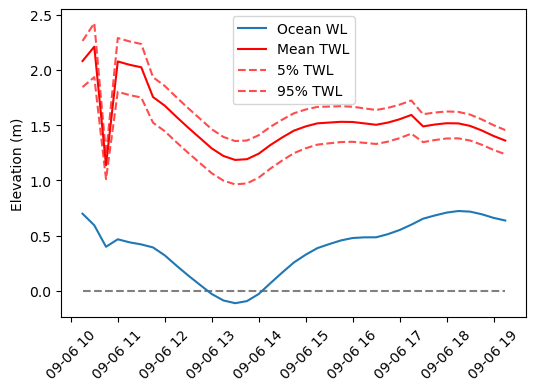

In [25]:
iR2max = np.argmax(R2_95)
tR2max = t.values[iR2max]
R2max = R2_95[iR2max]
TWL = zo+R2_95
print('R2 max: {} at {}'.format(R2max, tR2max) )

print('Range of mean R2:')
print(np.min(R2),np.max(R2))
print('Range of min R2:')
print(np.min(R2_5),np.max(R2_5) )

iTWLmax = np.argmax(TWL)
tTWLmax = t.values[iTWLmax]
TWLmax = TWL[iTWLmax]
print('TWL max: {} at {}'.format(TWLmax, tTWLmax) )

fig, ax0  = plt.subplots(1,1,figsize=(6,4),sharex=True)
ax0.plot(t,np.zeros_like(zo),'--',c='gray')
ax0.plot(t,zo,label='Ocean WL')
ax0.plot(t,zo+R2,'-r', label='Mean TWL')
ax0.plot(t,zo+R2_5,'--r', alpha=.7, label='5% TWL')
ax0.plot(t,zo+R2_95,'--r', alpha=.7, label='95% TWL')

ax0.set_ylabel('Elevation (m)')
plt.xticks(rotation=45, ha='center')
ax0.legend()

### Kludge alert - weird point (new run initialization?)

In [32]:
# Replace third point with local average
R2[2]=0.5*(R2[1]+R2[3])
R2_5[2]=0.5*(R2_5[1]+R2_5[3])
R2_95[2]=0.5*(R2_95[1]+R2_95[3])

Water depth at ocean wave point:  15.74471
Sound zmax: 2.7950313091278076 at 2019-09-06T12:45:00.075094016
Ocean zmax: 0.7238208055496216 at 2019-09-06T18:15:00.050624512
Ocean zmin: -0.11026206612586975 at 2019-09-06T13:29:59.985393664
Diff max: 2.8085360527038574 at 2019-09-06T13:00:00.078527488
izsmax =  10 izdmax =  11


C:\Users\csherwood\AppData\Local\Temp\1\ipykernel_16472\3065504099.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(tl)


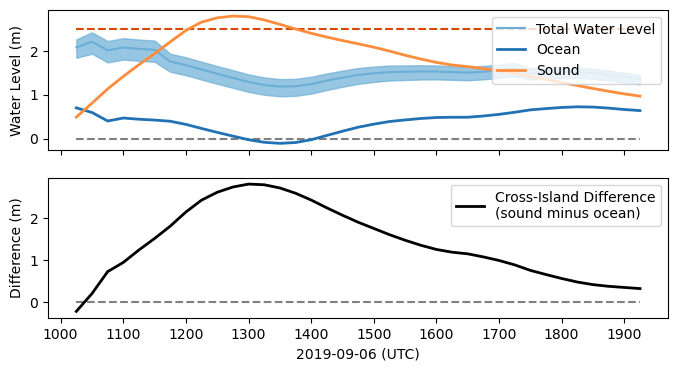

In [50]:
blues = ['#eff3ff','#bdd7e7','#6baed6','#2171b5']
greens = ['#edf8e9','#bae4b3','#74c476','#238b45']
oranges = ['#feedde','#fdbe85','#fd8d3c','#d94701']

tl = ['1000','1100','1200','1300','1400','1500','1600','1700','1800','1900']
zs = ds_CSYV.zeta[:,750,650].load()
zo = ds_CSYV.zeta[:,50, 650].load()
print('Water depth at ocean wave point: ', ds_CSYV.bath[0, 3, 650].values)
 

izsmax = np.argmax(zs.values)
tzsmax = t.values[izsmax]
zsmax = zs.values[izsmax]
print('Sound zmax: {} at {}'.format(zsmax, tzsmax) )
izomax = np.argmax(zo.values)
tzomax = t.values[izomax]
zomax = zo.values[izomax]
izomin = np.argmin(zo.values)
tzomin = t.values[izomin]
zomin = zo.values[izomin]
print('Ocean zmax: {} at {}'.format(zomax, tzomax) )
print('Ocean zmin: {} at {}'.format(zomin, tzomin) )

zdiff = zs.values - zo.values
izdmax = np.argmax(zdiff)
tdmax = t.values[izdmax]
zdmax = zdiff[izdmax]
print('Diff max: {} at {}'.format(zdmax, tdmax) )
print('izsmax = ', izsmax, 'izdmax = ', izdmax) 

fig, (ax0, ax1 ) = plt.subplots(2,1,figsize=(8,4),sharex=True)

ax0.plot(t,2.5*np.ones_like(zo),'--',c=oranges[3])
ax0.plot(t,np.zeros_like(zo),'--',c='gray')
# ax0.plot(t,zo+R2_95,'--', c=blues[3], alpha=.7, label='95% TWL')
ax0.fill_between(t, zo+R2_5, zo+R2_95, color=blues[2], alpha = .7 )
ax0.plot(t,zo+R2,'-', c=blues[2], label='Total Water Level')
# ax0.plot(t,zo+R2_5,'--', c=blues[3], alpha=.7, label='5% TWL')

ax0.plot(t,zo,c=blues[3],linewidth=2,label='Ocean')
ax0.plot(t,zs,c=oranges[2],linewidth=2,label='Sound')


ax0.set_ylabel('Water Level (m)')
ax0.legend(loc='upper right')

ax1.plot(t,np.zeros_like(zo),'--',c='gray')
ax1.plot(t,zs-zo,c='k',linewidth=2,label='Cross-Island Difference\n(sound minus ocean)')
ax1.legend(loc='upper right')
ax1.set_ylabel('Difference (m)')
ax1.set_xticklabels(tl)
#plt.xticks(rotation=-25, ha='center')
plt.xlabel('2019-09-06 (UTC)')
figname = 'all_runs_water_level_ts.png'
plt.savefig( figname, dpi=200, bbox_inches='tight')